# Makeup or No Makeup (Image)
Target (Y): Given an image, predict whether the person in the image is wearing makeup

## 1. Data Preparation

Import the required module first.

In [194]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  
import os
from PIL import Image
import pandas as pd
from sklearn import datasets, model_selection
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# DataLoader
Place the path containing the image and the image label (makeup, no_makeup) in the list.

In [515]:
train_path = 'data2/data/'

dirs = ['makeup', 'no_makeup']

data = []
label = []

for i, d in enumerate(dirs):
  files = os.listdir(train_path+d)
  
  for f in files:
    img = Image.open(train_path + d + '/' + f, 'r')
    # Adjust the image size to 60, 60.
    resize_img = img.resize((60, 60))
    # Split the image into RGB colors.
    r, g, b = resize_img.split()
    # Normalize each split image by dividing it by 255 to produce a value between 0 and 1.
    r_resize_img = np.asarray(np.float32(r) / 255.0)
    b_resize_img = np.asarray(np.float32(g) / 255.0)
    g_resize_img = np.asarray(np.float32(b) / 255.0)
    
    rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img])
    # Add this processed image. 
    data.append(rgb_resize_img)
    # label (makeup: 0, no_makeup: 1)
    label.append(i)

Check the images and labels. You can see that the size is 60 * 60.
The image size of 60 is not broken, and is suitable for adjusting the image size.

0


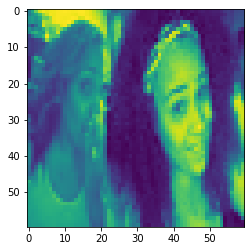

In [516]:
pd.DataFrame(data[0][0]).shape
plt.imshow(data[0][0])
print(label[0])

The images and labels are divided into training data and test data at 9:1.

The "DataLoader" then performs batch learning, data shuffle, and creates training and test data.

In [479]:
def data_load(batch_size) :
    data1 = np.array(data)
    label1 = np.array(label)

    train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data1, label1, test_size=0.1)

    train_X = torch.from_numpy(train_X).float()
    train_Y = torch.from_numpy(train_Y).long()

    test_X = torch.from_numpy(test_X).float()
    test_Y = torch.from_numpy(test_Y).long()

    train = TensorDataset(train_X, train_Y)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

    test = TensorDataset(test_X, test_Y)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [480]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# Proper learning rates should be set, not too large or too small, so that local minimum can be reached efficiently.
learning_rate = 0.001

Next code defines a convolutional neural network used in this tutorial.

In [521]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
    # Since it is color data, specify three color channels, 32 input channels, 5 kernel sizes, and 2 padding.
    nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
    #Even if the data in the batch changes, the normalizing man and variance values do not change.
    nn.BatchNorm2d(32),
    # A function that returns 0 if a value less than 0 is found, or if a value greater than 0 is returned as it is.
    nn.ReLU(),
    # the process of extracting features
    # Process for "pooling(sub sampling)" calculation results of "convolution layer"
    nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
    #Create two layers and set the output value to 32.
    nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(32),
    # It is used to prevent overfitting.
    nn.Dropout2d(),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2))
    # It then goes through a general neural network, with a input of 7200 in the first layer and a input of 100 in the second layer and a output of 10.
    self.fc = nn.Linear(32*25*9, 100)
    self.fc1 = nn.Linear(100, num_classes)
  # Return output
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    # Made from the same shape
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    return out

Below defines the training and prediction process.

In [522]:
# Train the model
def train_convnet(model, train_loader, num_epochs):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Display the progress
      if (i+1) % 10 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model      
def test_convnet(model, test_loader):
  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    # Display the result
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    return 100 * correct / total

In [524]:
acc = []
num_epochs_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for i in num_epochs_list :
    print("num_epochs = ", i)
    train_loader, test_loader = data_load(70)
    model = ConvNet(num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_convnet(model, train_loader, i)
    acc.append(test_convnet(model, test_loader))

num_epochs =  10
Epoch [1/10], Step [10/20], Loss: 3.7829
Epoch [1/10], Step [20/20], Loss: 3.4442
Epoch [2/10], Step [10/20], Loss: 1.3016
Epoch [2/10], Step [20/20], Loss: 0.3432
Epoch [3/10], Step [10/20], Loss: 0.9852
Epoch [3/10], Step [20/20], Loss: 0.7698
Epoch [4/10], Step [10/20], Loss: 1.0048
Epoch [4/10], Step [20/20], Loss: 0.9378
Epoch [5/10], Step [10/20], Loss: 0.6185
Epoch [5/10], Step [20/20], Loss: 0.6153
Epoch [6/10], Step [10/20], Loss: 0.5610
Epoch [6/10], Step [20/20], Loss: 0.8344
Epoch [7/10], Step [10/20], Loss: 0.4762
Epoch [7/10], Step [20/20], Loss: 0.7863
Epoch [8/10], Step [10/20], Loss: 0.5173
Epoch [8/10], Step [20/20], Loss: 1.0365
Epoch [9/10], Step [10/20], Loss: 0.6228
Epoch [9/10], Step [20/20], Loss: 0.6772
Epoch [10/10], Step [10/20], Loss: 0.6551
Epoch [10/10], Step [20/20], Loss: 0.7754
Test Accuracy of the model on the test images: 60.9271523178808 %
num_epochs =  20
Epoch [1/20], Step [10/20], Loss: 2.8115
Epoch [1/20], Step [20/20], Loss: 1.2

Epoch [36/40], Step [20/20], Loss: 0.2745
Epoch [37/40], Step [10/20], Loss: 0.1526
Epoch [37/40], Step [20/20], Loss: 0.2457
Epoch [38/40], Step [10/20], Loss: 0.4370
Epoch [38/40], Step [20/20], Loss: 0.1043
Epoch [39/40], Step [10/20], Loss: 0.1726
Epoch [39/40], Step [20/20], Loss: 0.1418
Epoch [40/40], Step [10/20], Loss: 0.2130
Epoch [40/40], Step [20/20], Loss: 0.1875
Test Accuracy of the model on the test images: 68.21192052980132 %
num_epochs =  50
Epoch [1/50], Step [10/20], Loss: 0.6614
Epoch [1/50], Step [20/20], Loss: 0.8583
Epoch [2/50], Step [10/20], Loss: 0.8987
Epoch [2/50], Step [20/20], Loss: 0.7837
Epoch [3/50], Step [10/20], Loss: 0.6630
Epoch [3/50], Step [20/20], Loss: 0.9343
Epoch [4/50], Step [10/20], Loss: 1.3094
Epoch [4/50], Step [20/20], Loss: 1.1631
Epoch [5/50], Step [10/20], Loss: 0.5281
Epoch [5/50], Step [20/20], Loss: 0.3406
Epoch [6/50], Step [10/20], Loss: 0.4553
Epoch [6/50], Step [20/20], Loss: 0.4584
Epoch [7/50], Step [10/20], Loss: 0.6878
Epoch

Epoch [42/60], Step [20/20], Loss: 0.0711
Epoch [43/60], Step [10/20], Loss: 0.1476
Epoch [43/60], Step [20/20], Loss: 0.1458
Epoch [44/60], Step [10/20], Loss: 0.1504
Epoch [44/60], Step [20/20], Loss: 0.0692
Epoch [45/60], Step [10/20], Loss: 0.2053
Epoch [45/60], Step [20/20], Loss: 0.1066
Epoch [46/60], Step [10/20], Loss: 0.2242
Epoch [46/60], Step [20/20], Loss: 0.1855
Epoch [47/60], Step [10/20], Loss: 0.1458
Epoch [47/60], Step [20/20], Loss: 0.2881
Epoch [48/60], Step [10/20], Loss: 0.1509
Epoch [48/60], Step [20/20], Loss: 0.3806
Epoch [49/60], Step [10/20], Loss: 0.1641
Epoch [49/60], Step [20/20], Loss: 0.0206
Epoch [50/60], Step [10/20], Loss: 0.3614
Epoch [50/60], Step [20/20], Loss: 0.1192
Epoch [51/60], Step [10/20], Loss: 0.1288
Epoch [51/60], Step [20/20], Loss: 0.3593
Epoch [52/60], Step [10/20], Loss: 0.2111
Epoch [52/60], Step [20/20], Loss: 0.2498
Epoch [53/60], Step [10/20], Loss: 0.2211
Epoch [53/60], Step [20/20], Loss: 0.1830
Epoch [54/60], Step [10/20], Loss:

Epoch [8/80], Step [20/20], Loss: 0.7426
Epoch [9/80], Step [10/20], Loss: 0.3871
Epoch [9/80], Step [20/20], Loss: 0.3519
Epoch [10/80], Step [10/20], Loss: 0.5203
Epoch [10/80], Step [20/20], Loss: 0.7004
Epoch [11/80], Step [10/20], Loss: 0.4900
Epoch [11/80], Step [20/20], Loss: 0.6619
Epoch [12/80], Step [10/20], Loss: 0.4466
Epoch [12/80], Step [20/20], Loss: 0.4321
Epoch [13/80], Step [10/20], Loss: 0.6623
Epoch [13/80], Step [20/20], Loss: 0.2830
Epoch [14/80], Step [10/20], Loss: 0.4934
Epoch [14/80], Step [20/20], Loss: 0.2081
Epoch [15/80], Step [10/20], Loss: 0.4754
Epoch [15/80], Step [20/20], Loss: 0.5439
Epoch [16/80], Step [10/20], Loss: 0.5175
Epoch [16/80], Step [20/20], Loss: 0.2748
Epoch [17/80], Step [10/20], Loss: 0.4551
Epoch [17/80], Step [20/20], Loss: 0.5002
Epoch [18/80], Step [10/20], Loss: 0.4377
Epoch [18/80], Step [20/20], Loss: 0.3674
Epoch [19/80], Step [10/20], Loss: 0.4237
Epoch [19/80], Step [20/20], Loss: 0.6933
Epoch [20/80], Step [10/20], Loss: 0.

Epoch [25/90], Step [20/20], Loss: 0.2284
Epoch [26/90], Step [10/20], Loss: 0.3996
Epoch [26/90], Step [20/20], Loss: 0.2492
Epoch [27/90], Step [10/20], Loss: 0.3905
Epoch [27/90], Step [20/20], Loss: 0.2830
Epoch [28/90], Step [10/20], Loss: 0.2428
Epoch [28/90], Step [20/20], Loss: 0.3955
Epoch [29/90], Step [10/20], Loss: 0.2254
Epoch [29/90], Step [20/20], Loss: 0.1661
Epoch [30/90], Step [10/20], Loss: 0.2745
Epoch [30/90], Step [20/20], Loss: 0.2970
Epoch [31/90], Step [10/20], Loss: 0.2402
Epoch [31/90], Step [20/20], Loss: 0.6563
Epoch [32/90], Step [10/20], Loss: 0.2382
Epoch [32/90], Step [20/20], Loss: 0.1397
Epoch [33/90], Step [10/20], Loss: 0.4262
Epoch [33/90], Step [20/20], Loss: 0.3452
Epoch [34/90], Step [10/20], Loss: 0.2097
Epoch [34/90], Step [20/20], Loss: 0.2070
Epoch [35/90], Step [10/20], Loss: 0.3160
Epoch [35/90], Step [20/20], Loss: 0.3835
Epoch [36/90], Step [10/20], Loss: 0.2906
Epoch [36/90], Step [20/20], Loss: 0.3466
Epoch [37/90], Step [10/20], Loss:

Epoch [32/100], Step [10/20], Loss: 0.2670
Epoch [32/100], Step [20/20], Loss: 0.2980
Epoch [33/100], Step [10/20], Loss: 0.2509
Epoch [33/100], Step [20/20], Loss: 0.3552
Epoch [34/100], Step [10/20], Loss: 0.4071
Epoch [34/100], Step [20/20], Loss: 0.1349
Epoch [35/100], Step [10/20], Loss: 0.1607
Epoch [35/100], Step [20/20], Loss: 0.4402
Epoch [36/100], Step [10/20], Loss: 0.2126
Epoch [36/100], Step [20/20], Loss: 0.2755
Epoch [37/100], Step [10/20], Loss: 0.1710
Epoch [37/100], Step [20/20], Loss: 0.1401
Epoch [38/100], Step [10/20], Loss: 0.2568
Epoch [38/100], Step [20/20], Loss: 0.4501
Epoch [39/100], Step [10/20], Loss: 0.1587
Epoch [39/100], Step [20/20], Loss: 0.2802
Epoch [40/100], Step [10/20], Loss: 0.2513
Epoch [40/100], Step [20/20], Loss: 0.1637
Epoch [41/100], Step [10/20], Loss: 0.3170
Epoch [41/100], Step [20/20], Loss: 0.1781
Epoch [42/100], Step [10/20], Loss: 0.0978
Epoch [42/100], Step [20/20], Loss: 0.2486
Epoch [43/100], Step [10/20], Loss: 0.1820
Epoch [43/1

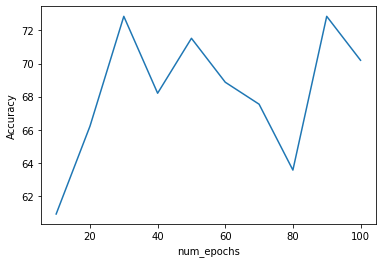

Max Accuracy =  72.8476821192053 num_epochs =  30


In [525]:
fig = plt.figure()
plt.plot(num_epochs_list, acc )
plt.ylabel('Accuracy')
plt.xlabel('num_epochs')
plt.show()
print("Max Accuracy = ", max(acc), "num_epochs = ", num_epochs_list[acc.index(max(acc))])

In [526]:
learning_list = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
acc2 = []
for i in learning_list :
    print("learning_rate = ", i)
    train_loader, test_loader = data_load(70)
    model = ConvNet(num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = i)
    train_convnet(model, train_loader, 30)
    acc2.append(test_convnet(model, test_loader))

learning_rate =  0.5
Epoch [1/30], Step [10/20], Loss: 456.6553
Epoch [1/30], Step [20/20], Loss: 12.1419
Epoch [2/30], Step [10/20], Loss: 19.4033
Epoch [2/30], Step [20/20], Loss: 43.9798
Epoch [3/30], Step [10/20], Loss: 22.0733
Epoch [3/30], Step [20/20], Loss: 4.7114
Epoch [4/30], Step [10/20], Loss: 7.6638
Epoch [4/30], Step [20/20], Loss: 23.5263
Epoch [5/30], Step [10/20], Loss: 17.5526
Epoch [5/30], Step [20/20], Loss: 19.2237
Epoch [6/30], Step [10/20], Loss: 17.7156
Epoch [6/30], Step [20/20], Loss: 2.2520
Epoch [7/30], Step [10/20], Loss: 13.5275
Epoch [7/30], Step [20/20], Loss: 0.4617
Epoch [8/30], Step [10/20], Loss: 2.4467
Epoch [8/30], Step [20/20], Loss: 10.6828
Epoch [9/30], Step [10/20], Loss: 22.0667
Epoch [9/30], Step [20/20], Loss: 9.2172
Epoch [10/30], Step [10/20], Loss: 2.9700
Epoch [10/30], Step [20/20], Loss: 9.4785
Epoch [11/30], Step [10/20], Loss: 35.7488
Epoch [11/30], Step [20/20], Loss: 15.9616
Epoch [12/30], Step [10/20], Loss: 2.1502
Epoch [12/30], S

Epoch [6/30], Step [10/20], Loss: 0.6127
Epoch [6/30], Step [20/20], Loss: 0.6697
Epoch [7/30], Step [10/20], Loss: 0.6082
Epoch [7/30], Step [20/20], Loss: 0.5337
Epoch [8/30], Step [10/20], Loss: 0.6469
Epoch [8/30], Step [20/20], Loss: 0.5114
Epoch [9/30], Step [10/20], Loss: 0.5887
Epoch [9/30], Step [20/20], Loss: 0.5901
Epoch [10/30], Step [10/20], Loss: 0.6197
Epoch [10/30], Step [20/20], Loss: 0.5752
Epoch [11/30], Step [10/20], Loss: 0.5769
Epoch [11/30], Step [20/20], Loss: 0.5552
Epoch [12/30], Step [10/20], Loss: 0.5118
Epoch [12/30], Step [20/20], Loss: 0.5524
Epoch [13/30], Step [10/20], Loss: 0.5682
Epoch [13/30], Step [20/20], Loss: 0.4596
Epoch [14/30], Step [10/20], Loss: 0.6397
Epoch [14/30], Step [20/20], Loss: 0.5639
Epoch [15/30], Step [10/20], Loss: 0.5777
Epoch [15/30], Step [20/20], Loss: 0.5248
Epoch [16/30], Step [10/20], Loss: 0.4738
Epoch [16/30], Step [20/20], Loss: 0.6326
Epoch [17/30], Step [10/20], Loss: 0.5482
Epoch [17/30], Step [20/20], Loss: 0.6378


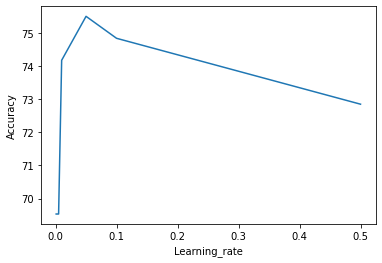

Max Accuracy =  75.49668874172185 Learning_rate =  0.05


In [528]:
fig = plt.figure()
plt.plot(learning_list, acc2 )
plt.ylabel('Accuracy')
plt.xlabel('Learning_rate')
plt.show()
print("Max Accuracy = ", max(acc2), "Learning_rate = ", learning_list[acc2.index(max(acc2))])

In [530]:
train_loader, test_loader = data_load(70)
model = ConvNet(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
train_convnet(model, train_loader, 30)
test_convnet(model, test_loader)

Epoch [1/30], Step [10/20], Loss: 169.6581
Epoch [1/30], Step [20/20], Loss: 3.0600
Epoch [2/30], Step [10/20], Loss: 0.5992
Epoch [2/30], Step [20/20], Loss: 0.6284
Epoch [3/30], Step [10/20], Loss: 0.6848
Epoch [3/30], Step [20/20], Loss: 0.5767
Epoch [4/30], Step [10/20], Loss: 0.6767
Epoch [4/30], Step [20/20], Loss: 0.5942
Epoch [5/30], Step [10/20], Loss: 0.6352
Epoch [5/30], Step [20/20], Loss: 0.5930
Epoch [6/30], Step [10/20], Loss: 0.5780
Epoch [6/30], Step [20/20], Loss: 0.5969
Epoch [7/30], Step [10/20], Loss: 0.6616
Epoch [7/30], Step [20/20], Loss: 0.5963
Epoch [8/30], Step [10/20], Loss: 0.6050
Epoch [8/30], Step [20/20], Loss: 0.6311
Epoch [9/30], Step [10/20], Loss: 0.5709
Epoch [9/30], Step [20/20], Loss: 0.6867
Epoch [10/30], Step [10/20], Loss: 0.6225
Epoch [10/30], Step [20/20], Loss: 0.5956
Epoch [11/30], Step [10/20], Loss: 0.6110
Epoch [11/30], Step [20/20], Loss: 0.6298
Epoch [12/30], Step [10/20], Loss: 0.6478
Epoch [12/30], Step [20/20], Loss: 0.7147
Epoch [1

74.17218543046357